In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_t_4_em4_random_basis_mesh_60_pmap_over_filling.npz')


final_ground_state_e_diff_density = final_result['gse']
filling_arr = final_result['filling']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(0.00013136674935187997)

In [4]:
np.max(final_e_difference)

np.float64(1.4548593840757462e-07)

In [5]:
np.all(any_bi_fail)==False

np.True_

### the convergence is not as good, but probably no need to delete any points right now

## Phase Analysis

In [6]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)
sorted_e_fermi = np.take_along_axis(final_e_fermi, sorted_ground_state_e_index, axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [7]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(filling_mesh.shape)
nematic_measure = np.zeros(filling_mesh.shape)
f_phase = np.zeros(filling_mesh.shape)
f_measure = np.zeros(filling_mesh.shape)
f_max_measure = np.zeros(filling_mesh.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

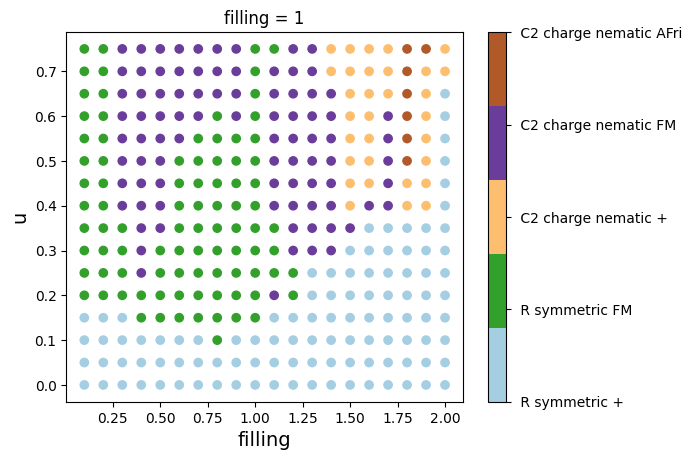

In [8]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(filling_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

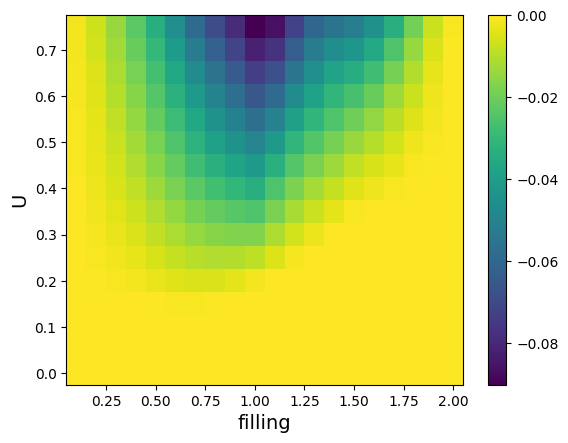

In [9]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

### band structure plot

In [10]:
from functions_parameters.universal_parameters import a, b
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell
from functions_parameters.jax_schf_kernel import schf_single_job

In [11]:
num_bands = 3
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])
temperature = 4E-4

# high-symmetry k-path
k_path = np.array([[0, 0],
                   [1 / 2, 0],
                   [1 / 3, 1 / 3],
                   [0, 0],
                   [0, 1 / 2],
                   [-1 / 3, 2 / 3],
                   [0, 0],
                   [-1 / 2, 1 / 2],
                   [-2 / 3, 1 / 3],
                   [0, 0]])
num_k = 30
# obtain the distance of each segment of k path
k_path_distance = [0, la.norm((k_path[1] - k_path[0]) @ b), ]
for i in range(k_path.shape[0] - 2):
    k_path_distance += [
        k_path_distance[-1] + la.norm((k_path[i + 2] - k_path[i + 1]) @ b)]
# obtain the distance for each point along k path for plotting
k_path_line = np.array(
    [np.linspace(k_path_distance[i], k_path_distance[i + 1], num_k) for i in range(len(k_path_distance) - 1)]).reshape(
    (-1))
high_symmetry_k = [k_path_line[num_k * i] for i in range(k_path.shape[0] - 1)]
high_symmetry_k += [k_path_line[-1], ]
# xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
high_symmetry_spectrum = np.zeros((k_path_line.shape[0], num_bands))
k_points_along_path = np.vstack([np.linspace(k_path[i], k_path[i + 1], num_k) for i in range(k_path.shape[0] - 1)])
k_points_along_path = np.array([k @ b for k in k_points_along_path])

In [12]:
filling_index = -6
filling_i = filling_arr[filling_index]/2

In [13]:
filling_i

np.float64(0.75)

In [14]:
basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_points_along_path)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)
dict_ref = prepare_reference_state(filling_i, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)

u_index = -1
u_input = u_arr[u_index]
v_arr = np.array((u_input, u_input))/2

input_d = sorted_density[filling_index, u_index,0]
input_bond = sorted_bond[filling_index, u_index,0]


In [15]:
# prepare the initial mean-field terms
h_mean_u = dict_ref['h_mean_u']
h_mean_v = dict_ref['h_mean_v']
h_mean_initial_u = h_mean_u*u_input
h_mean_initial = h_mean_initial_u[None, :, :, :] + np.einsum('Nsvmn,v->Nsmn', h_mean_v,v_arr)

# prepare the input mean-field terms
h_mean_input_u = mean_field_u(input_d, u_input)
h_mean_input_v_o = hartree_spinor(a_lists, v_arr, input_d)
h_mean_input_o = h_mean_input_u + h_mean_input_v_o
# k-dependent part
h_mean_input_v_k = fock_spinor(input_bond, v_arr, phase_pos)
h_mean_input = h_mean_input_o[None, :, :, :] + h_mean_input_v_k


spectrum_nematic = np.zeros((k_points_along_path.shape[0], num_bands*2))
spectrum_original = np.zeros((k_points_along_path.shape[0], num_bands))
for i in range(k_points_along_path.shape[0]):
    e_o, _= la.eigh(Htb[i])
    spectrum_original[i,:] = e_o
    hup = Htb[i] + h_mean_input[i,0] - h_mean_initial[i,0]
    e_up,_ = la.eigh(hup)
    hdn = Htb[i] + h_mean_input[i,1] - h_mean_initial[i,1]
    e_dn,_ = la.eigh(hdn)
    spectrum_nematic[i,:] = np.concatenate((e_up, e_dn))

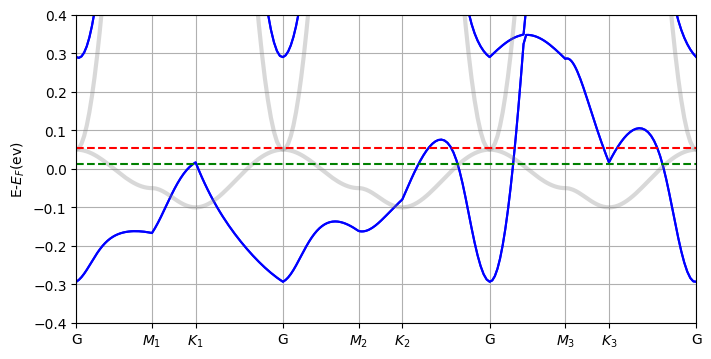

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(k_path_line, spectrum_nematic, 'b-')
plt.plot(k_path_line, spectrum_original, 'grey', alpha = 0.3, linewidth=3)
plt.hlines(dict_ref['e_fermi'], high_symmetry_k[0], high_symmetry_k[-1], colors='green', linestyles='--')
plt.hlines(sorted_e_fermi[filling_index, u_index,0], high_symmetry_k[0], high_symmetry_k[-1], colors='red', linestyles='--')
plt.xlim(high_symmetry_k[0], high_symmetry_k[-1])
plt.ylim(-0.4,0.4)
plt.xticks(high_symmetry_k, xticks_k)
plt.ylabel('E-' + r'$E_{F}$' + '(ev)')
# plt.title(
#     'Band structure of rotated ' + r'$d_{yz}$' + ' and ' + r'$d_{x^{2}-y^{2}}$' + ' with SOC strength %i' % soc_strength)
# plt.ylim(-0.1, 0.04)
plt.grid()

In [17]:
sorted_e_fermi[filling_index, u_index,0]

np.float64(0.05370200206373284)

# a better phase diagram

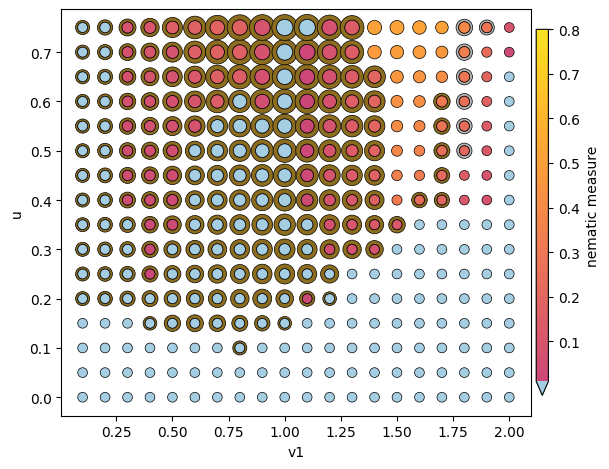

In [18]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(u_mesh.shape)
CFG = PlotConfig(nem_vmax=0.8, energy_max=0.2)
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    filling_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

In [19]:
sorted_density[9,-12,0]

array([[0.28440774+1.03663631e-25j, 0.28440774-9.16140833e-20j,
        0.28440774-7.75370031e-20j],
       [0.04892559-1.21042577e-26j, 0.04892559+1.63983469e-20j,
        0.04892559+2.48664496e-20j]])

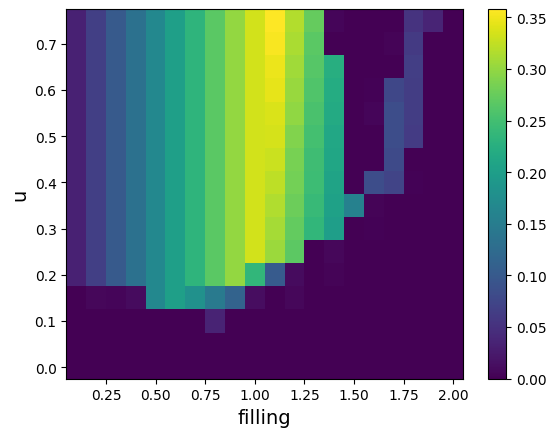

In [20]:
plt.pcolormesh(filling_mesh, u_mesh, f_measure)
plt.colorbar()
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
plt.show()

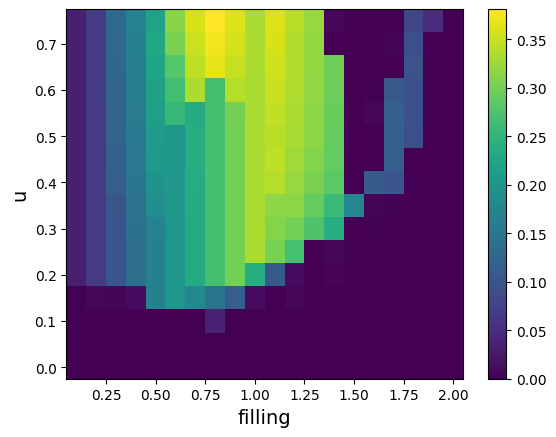

In [21]:
plt.pcolormesh(filling_mesh, u_mesh, f_max_measure)
plt.colorbar()
plt.xlabel('filling', size = '14')
plt.ylabel('u', size = '14')
plt.show()

# check the degeneracy

In [22]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase

In [23]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [24]:
degenerate_index

(array([ 0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,
         9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        12, 13, 13, 15, 15, 16, 16, 18, 18, 18, 19, 19, 19, 19]),
 array([ 3,  3, 13, 15,  3,  8,  3,  4,  5,  6,  7,  8,  6,  7,  7,  8,  9,
        10,  8,  9, 10,  2,  8,  9, 10, 11, 12, 11, 12, 14, 15,  3,  9, 10,
        11, 12,  4,  9, 10, 11, 12, 13, 14, 15,  3,  4,  6, 12, 13, 14, 15,
         5,  4,  5,  6,  7,  7, 12,  6,  7, 15,  8,  9, 10, 11]),
 array([3, 7, 4, 2, 7, 3, 7, 4, 4, 4, 4, 4, 6, 5, 6, 6, 6, 1, 6, 6, 6, 7,
        6, 6, 6, 6, 1, 6, 2, 3, 3, 7, 6, 6, 6, 6, 4, 2, 5, 1, 1, 2, 4, 4,
        7, 7, 6, 3, 3, 3, 3, 3, 7, 7, 7, 1, 6, 6, 9, 3, 3, 9, 9, 6, 7]))

In [25]:
unique_phase_index_degenerate = np.unique(degenerate_state_diagram)
unique_phase_name_degenerate = [phase_1_1[i] for i in np.int_(unique_phase_index_degenerate) if i != -1]

In [26]:
unique_phase_name_degenerate

[' C2 charge nematic +']

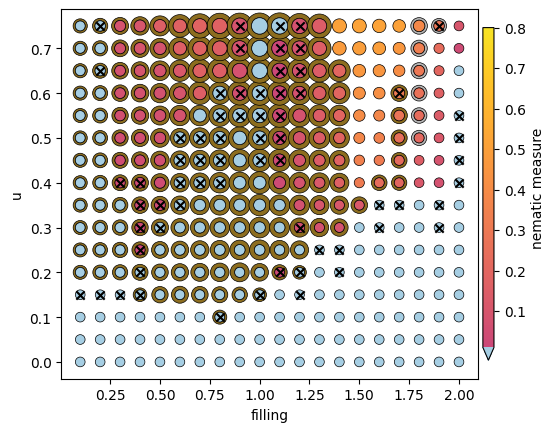

In [30]:
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    filling_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("filling")
ax.set_ylabel("u")
ax.scatter(filling_arr[degenerate_index[0]], u_arr[degenerate_index[1]], marker='x', color='black', zorder=10)

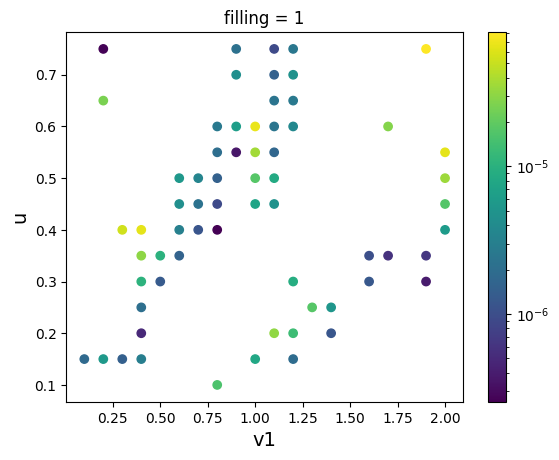

In [29]:
import matplotlib

plt.scatter(filling_arr[degenerate_index[0]], u_arr[degenerate_index[1]], c=sorted_ground_state_e[degenerate_index]-sorted_ground_state_e[degenerate_index[0],degenerate_index[1],0],zorder=10,marker='o',cmap='viridis',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 1')
plt.show()